In [1]:
# Import libraries
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

# Ignore all warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
base_train_df = pd.read_csv(r'C:\Users\wanyanwendi\Desktop\dataset\rohlik-orders-forecasting-challenge\train.csv')
base_train_df.head(5)

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


In [3]:
base_test_df = pd.read_csv(r'C:\Users\wanyanwendi\Desktop\dataset\rohlik-orders-forecasting-challenge\test.csv')
base_test_df.head(5)

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,NaN,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,NaN,0,0,0,0,Prague_1_2024-03-20


In [4]:
# Base features
base_features = base_test_df.drop(columns=['id']).columns
test_id = base_test_df['id']

In [5]:
# train_df = pd.concat([base_train_df[base_features], base_train_df['orders']], axis=1)
train_df = pd.concat([base_train_df[base_features], base_train_df['orders']], axis=1)
test_df = base_test_df[base_features]

Preprocessing

In [6]:
# Info of train or test datasets
print(train_df.info())
print('='*60)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7340 non-null   object 
 1   date                    7340 non-null   object 
 2   holiday_name            218 non-null    object 
 3   holiday                 7340 non-null   int64  
 4   shops_closed            7340 non-null   int64  
 5   winter_school_holidays  7340 non-null   int64  
 6   school_holidays         7340 non-null   int64  
 7   orders                  7340 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 458.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   warehouse               397 non-null    object
 1   date                    397 no

In [7]:
# Concat train data + test data
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [8]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7737 entries, 0 to 7736
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7737 non-null   object 
 1   date                    7737 non-null   object 
 2   holiday_name            235 non-null    object 
 3   holiday                 7737 non-null   int64  
 4   shops_closed            7737 non-null   int64  
 5   winter_school_holidays  7737 non-null   int64  
 6   school_holidays         7737 non-null   int64  
 7   orders                  7340 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 483.7+ KB


In [9]:
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
holiday,7737.0,0.029340,0.168767,0.0,0.0,0.0,0.00,1.0
shops_closed,7737.0,0.011374,0.106047,0.0,0.0,0.0,0.00,1.0
winter_school_holidays,7737.0,0.029469,0.169127,0.0,0.0,0.0,0.00,1.0
school_holidays,7737.0,0.010340,0.101165,0.0,0.0,0.0,0.00,1.0
orders,7340.0,5535.443869,2182.680279,790.0,4434.0,5370.0,7009.25,18139.0


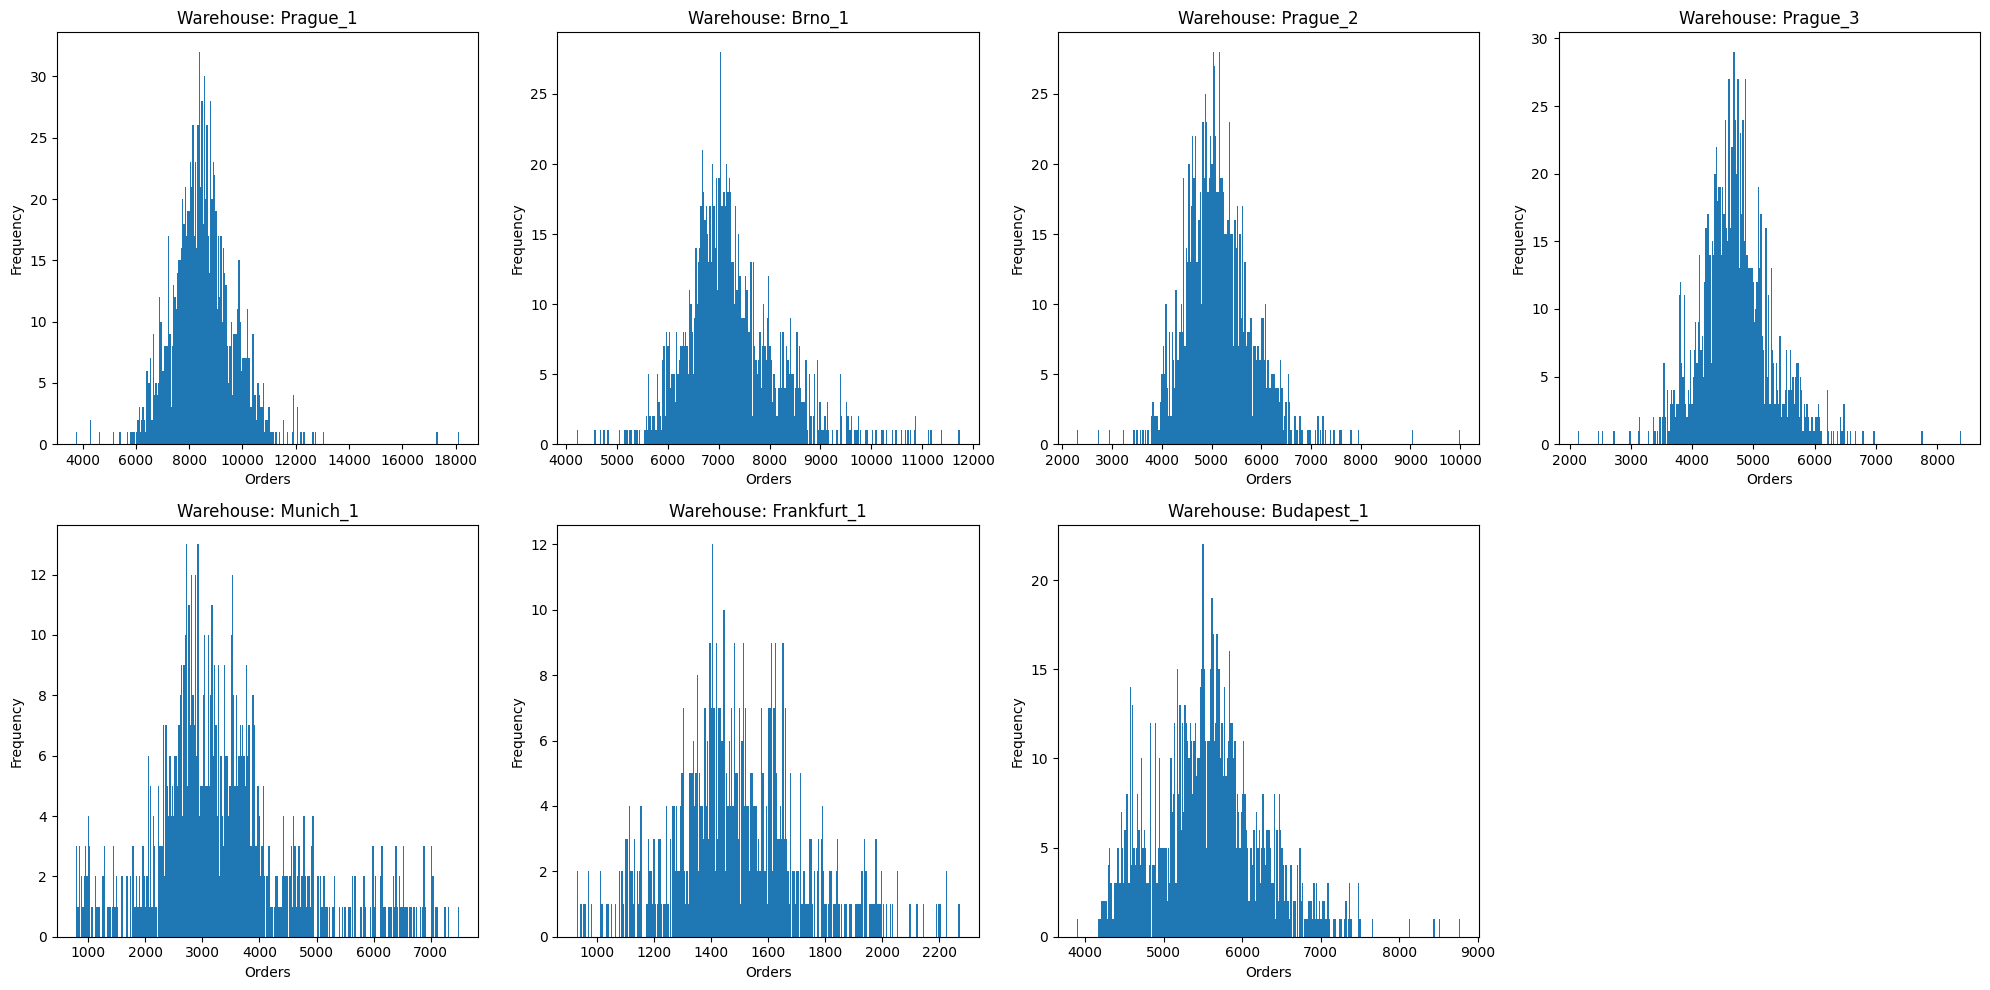

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Plot histograms
for i, wh in enumerate(all_df['warehouse'].unique()):
    ax = axes[i]
    ax.hist(all_df[all_df['warehouse'] == wh]['orders'], bins=300)
    ax.set_title(f'Warehouse: {wh}')
    ax.set_xlabel('Orders')
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
# Convert the date column to a processable format 
date_start = pd.to_datetime(all_df['date'], errors='coerce').min()

date_col = ['date']
for _col in date_col:
    date_col = pd.to_datetime(all_df[_col], errors='coerce')
    all_df[_col + "_year"] = date_col.dt.year.fillna(-1)
    all_df[_col + "_month"] = date_col.dt.month.fillna(-1)
    all_df[_col + "_day"] = date_col.dt.day.fillna(-1)
    all_df[_col + "_day_of_week"] = date_col.dt.dayofweek.fillna(-1)
    all_df[_col + "_week_of_year"] = date_col.dt.isocalendar().week.fillna(-1)

    all_df[_col + "_num"] = (date_col-date_start).dt.days.fillna(-1)
    #train['numday'] = (train['date']-date_start).dt.days
    all_df[_col + "_day_of_year"] = date_col.dt.dayofyear.fillna(-1)
    all_df[_col + "_day_of_year"] = np.where( (all_df[_col + "_year"]%4==0)&(all_df[_col + "_month"]>2), all_df[_col + "_day_of_year"]-1, all_df[_col + "_day_of_year"])

    all_df[_col + "_quarter"] = date_col.dt.quarter.fillna(-1)
    all_df[_col + "_is_month_start"] = date_col.dt.is_month_start.astype(int).fillna(-1)
    all_df[_col + "_is_month_end"] = date_col.dt.is_month_end.astype(int).fillna(-1)
    all_df[_col + "_is_quarter_start"] = date_col.dt.is_quarter_start.astype(int).fillna(-1)
    all_df[_col + "_is_quarter_end"] = date_col.dt.is_quarter_end.astype(int).fillna(-1)
    # all_df[_col + '_is_weekend'] = all_df['date_day_of_week'].isin([5, 6]).astype(int)
    # all_df.drop(_col, axis=1, inplace=True)

all_df['date'] = pd.to_datetime(all_df['date'])
all_df


,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,orders,date_year,date_month,date_day,date_day_of_week,date_week_of_year,date_num,date_day_of_year,date_quarter,date_is_month_start,date_is_month_end,date_is_quarter_start,date_is_quarter_end
0,Prague_1,2020-12-05,NaN,0,0,0,0,6895.0,2020,12,5,5,49,0,339,4,0,0,0,0
1,Prague_1,2020-12-06,NaN,0,0,0,0,6584.0,2020,12,6,6,49,1,340,4,0,0,0,0
2,Prague_1,2020-12-07,NaN,0,0,0,0,7030.0,2020,12,7,0,50,2,341,4,0,0,0,0
3,Prague_1,2020-12-08,NaN,0,0,0,0,6550.0,2020,12,8,1,50,3,342,4,0,0,0,0
4,Prague_1,2020-12-09,NaN,0,0,0,0,6910.0,2020,12,9,2,50,4,343,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7732,Budapest_1,2024-05-11,NaN,0,0,0,0,NaN,2024,5,11,5,19,1253,131,2,0,0,0,0
7733,Budapest_1,2024-05-12,NaN,0,0,0,0,NaN,2024,5,12,6,19,1254,132,2,0,0,0,0
7734,Budapest_1,2024-05-13,NaN,0,0,0,0,NaN,2024,5,13,0,20,1255,133,2,0,0,0,0
7735,Budapest_1,2024-05-14,NaN,0,0,0,0,NaN,2024,5,14,1,20,1256,134,2,0,0,0,0


In [12]:
# Apply sine and cosine transformations
#all_df['year_sin'] = all_df['date_year'] * np.sin(2 * pi * all_df['date_year'])
#all_df['year_cos'] = all_df['date_year'] * np.cos(2 * pi * all_df['date_year'])
all_df['month_sin'] = all_df['date_month'] * np.sin(2 * pi * all_df['date_month'])
all_df['month_cos'] = all_df['date_month'] * np.cos(2 * pi * all_df['date_month'])
all_df['day_sin'] = all_df['date_day'] * np.sin(2 * pi * all_df['date_day'])
all_df['day_cos'] = all_df['date_day'] * np.cos(2 * pi * all_df['date_day'])

all_df['year_sin'] = np.sin(2 * pi * all_df["date_day_of_year"])
all_df['year_cos'] = np.cos(2 * pi * all_df['date_day_of_year'])

In [13]:
# Replace Null values with None
all_df['holiday_name'].fillna('None', inplace=True)

In [14]:
# OneHotEncoding → holiday_name
enc = OneHotEncoder(sparse_output=False)

holiday_encoded = enc.fit_transform(all_df[['holiday_name']])
encoded_df = pd.DataFrame(holiday_encoded, columns=enc.get_feature_names_out(['holiday_name']))
all_df = pd.concat([all_df, encoded_df], axis=1)

# drop holiday_name column
all_df = all_df.drop('holiday_name', axis=1)

In [15]:
# LabelEncoding → warehouse column
le = preprocessing.LabelEncoder()

all_df['warehouse'] = le.fit_transform(all_df['warehouse'])

In [16]:
# Obtain the data for the day before or after a holiday
all_df['holiday_before'] = all_df['holiday'].shift(1).fillna(0).astype(int)
all_df['holiday_after'] = all_df['holiday'].shift(-1).fillna(0).astype(int)

In [17]:
# Convert the data back to train_df and test_df
train_df_le = all_df[~all_df['orders'].isnull()]
test_df_le = all_df[all_df['orders'].isnull()]

train_df_le = train_df_le.drop(columns=['date'], axis=1)
test_df_le = test_df_le.drop(columns=['date'], axis=1)

Modeling (Ensemble + Stacking)
Ensemble:
LightGBM
XGBoost
RandomForest
CatBoost
Logistic Regression
Ada Boost
Decision Tree
Gradient Boost

In [18]:
# split train data

# Set random seed 
random_seed = 777 

X = train_df_le.drop(columns=['orders'])
y = train_df_le['orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [19]:
# Cross validation

# Number of splits for cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# Placeholders for stacking features
stacking_train = np.zeros((X_train.shape[0], 8))
stacking_test = np.zeros((X_test.shape[0],8))

# Initialize base models
lgb_model = lgb.LGBMRegressor(random_state=random_seed)
xgb_model = xgb.XGBRegressor(random_state=random_seed)
cat_model = CatBoostRegressor(silent=True, random_state=random_seed)
rf_model = RandomForestRegressor(random_state=random_seed)
lr_model = LogisticRegression(random_state=random_seed)
ad_model = AdaBoostRegressor(random_state=random_seed)
dt_model = DecisionTreeRegressor(random_state=random_seed)
gb_model = GradientBoostingRegressor(random_state=random_seed)

# Train base models with cross-validation
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    # Train each base model
    lgb_model.fit(X_tr, y_tr)
    xgb_model.fit(X_tr, y_tr)
    cat_model.fit(X_tr, y_tr)
    rf_model.fit(X_tr, y_tr)
    lr_model.fit(X_tr, y_tr)
    ad_model.fit(X_tr, y_tr)
    dt_model.fit(X_tr, y_tr)
    gb_model.fit(X_tr, y_tr)

    # Predict on validation set
    stacking_train[val_idx, 0] = lgb_model.predict(X_val)
    stacking_train[val_idx, 1] = xgb_model.predict(X_val)
    stacking_train[val_idx, 2] = cat_model.predict(X_val)
    stacking_train[val_idx, 3] = rf_model.predict(X_val)
    stacking_train[val_idx, 4] = lr_model.predict(X_val)
    stacking_train[val_idx, 5] = ad_model.predict(X_val)
    stacking_train[val_idx, 6] = dt_model.predict(X_val)
    stacking_train[val_idx, 7] = gb_model.predict(X_val)

    # Predict on test set
    stacking_test[:, 0] += lgb_model.predict(X_test) / n_splits
    stacking_test[:, 1] += xgb_model.predict(X_test) / n_splits
    stacking_test[:, 2] += cat_model.predict(X_test) / n_splits
    stacking_test[:, 3] += rf_model.predict(X_test) / n_splits
    stacking_test[:, 4] += lr_model.predict(X_test) / n_splits
    stacking_test[:, 5] += ad_model.predict(X_test) / n_splits
    stacking_test[:, 6] += dt_model.predict(X_test) / n_splits
    stacking_test[:, 7] += gb_model.predict(X_test) / n_splits

    
# Train meta-model
# meta_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
# meta_model =
meta_model_1 = LGBMRegressor(n_estimators=150, num_leaves=15, learning_rate=0.05
, colsample_bytree=0.6, lambda_l1=0.2, lambda_l2=0.2, random_state=random_seed)
meta_model_2 = CatBoostRegressor(verbose=0, random_state = random_seed)

meta_model_1.fit(stacking_train, y_train)
meta_model_2.fit(stacking_train, y_train)


best_iteration_1 = meta_model_1.best_iteration_
# Predict on test set using meta-model

meta_pred_1 = meta_model_1.predict(stacking_test)
meta_pred_2 = meta_model_2.predict(stacking_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 5284, number of used features: 25
[LightGBM] [Info] Start training from score 5553.599924
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 5284, number of used features: 25
[LightGBM] [Info] Start training from score 5538.727290
[LightGBM] [Warning] Found

In [20]:
# Evaluate results

weights = {
    'cat_test_preds': 0.55,  
    'lgb_test_preds': 0.45,  
}

cat_test_preds_weighted = meta_pred_2 * weights['cat_test_preds']
lgb_test_preds_weighted = meta_pred_1 * weights['lgb_test_preds']

ensemble_preds = cat_test_preds_weighted + lgb_test_preds_weighted
mape = mean_absolute_percentage_error(y_test, ensemble_preds)
print(f'Simple Average Ensemble Model MAPE: {mape:.4f}')

Simple Average Ensemble Model MAPE: 0.0312


In [21]:
# Prediction
# test_df_le = test_df_le.drop(columns=['date', 'orders'])
test_df_le = test_df_le.drop(columns=['orders'])

lgb_pred_test = lgb_model.predict(test_df_le)
xgb_pred_test = xgb_model.predict(test_df_le)
cat_pred_test = cat_model.predict(test_df_le)
rf_pred_test = rf_model.predict(test_df_le)
lr_pred_test = lr_model.predict(test_df_le)
ad_pred_test = ad_model.predict(test_df_le)
dt_pred_test = dt_model.predict(test_df_le)
gb_pred_test = gb_model.predict(test_df_le)

# stacking_test_df_le = np.vstack([lgb_pred_test, xgb_pred_test, cat_pred_test, rf_pred_test]).T
stacking_test_df_le = np.vstack([lgb_pred_test, xgb_pred_test, cat_pred_test, rf_pred_test, lr_pred_test, ad_pred_test, dt_pred_test, gb_pred_test]).T


submit_pred_1 = meta_model_1.predict(stacking_test_df_le)
submit_pred_2 = meta_model_2.predict(stacking_test_df_le)
weights = {
    'cat_test_preds': 0.55,  
    'lgb_test_preds': 0.45,  
}

cat_test_preds_weighted = submit_pred_2 * weights['cat_test_preds']
lgb_test_preds_weighted = submit_pred_1 * weights['lgb_test_preds']
submit_pred = cat_test_preds_weighted + lgb_test_preds_weighted

[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2


Submit

In [22]:
submission = pd.DataFrame({
    'id': test_id,
    'Target': submit_pred
})

# Save
submission.to_csv('submission.csv', index=False)

print(submission)

                        id        Target
0      Prague_1_2024-03-16  10501.375499
1      Prague_1_2024-03-17  10348.296362
2      Prague_1_2024-03-18  10028.941275
3      Prague_1_2024-03-19   9612.658442
4      Prague_1_2024-03-20   9583.428943
..                     ...           ...
392  Budapest_1_2024-05-11   7016.207345
393  Budapest_1_2024-05-12   6352.931995
394  Budapest_1_2024-05-13   6435.709608
395  Budapest_1_2024-05-14   6332.124398
396  Budapest_1_2024-05-15   6424.432054

[397 rows x 2 columns]
